In [0]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import seaborn as sns
import scipy
import string


sns.set_style("white")
pyplot.style.use('default')

In [0]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/copainter_data'


In [3]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  assert data_path.startswith('/content/gdrive/My Drive/'), \
         'Google Drive paths must start with "/content/gdrive/My Drive/"!'
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load DTWs matrices


In [31]:
def loaditer(name):    
  data_pathb = data_path +'/handwriting/no_scale/strokes/DTWs'
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    d = json.loads(line)
    d['dtw_matrix'] = np.array(d['dtw_matrix'])
    yield d

    
def loadn(name, n):
  it = loaditer(name)
  return list(itertools.islice(it, 0, n))



def loadALine(name,n):
  count = 0
  data_pathb = data_path +'/handwriting/no_scale/strokes/DTWs'
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    if(n == count):
      d = json.loads(line)
      return d
    else:
      count +=1
      continue
  

n = 1
print('Loading {} instances of "{}"...'.format(n, 'a'), end='')
sample = loadn('c', 10)
print('done.')

Loading 1 instances of "a"...done.


In [32]:
sample[0].keys()

dict_keys(['letter', 'dtw_matrix'])

In [33]:
np.shape(sample[0]['dtw_matrix'])

(119, 119)

## Plot Histogram

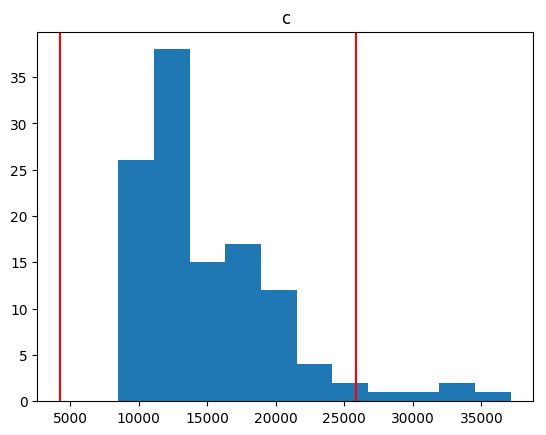

In [34]:

def plotHist(sample):
  d = sample['dtw_matrix']
  cf = np.mean(d,axis=1)
  a = np.hstack(cf)
  pyplot.hist(a, bins='auto')  # arguments are passed to np.histogram
  t0 = np.mean(cf) - 2*np.std(cf)
  t1 = np.mean(cf) + 2*np.std(cf)
  
  pyplot.axvline(x=t0, color='r')
  pyplot.axvline(x=t1, color='r')
  pyplot.title(sample['letter'])


plotHist(sample[0])
pyplot.show()


In [0]:
def loadAllLetters():
  charList = list(string.ascii_letters)
  llist = []
  for c in charList:
    sample = loadn(c, 1)[0]
    llist.append(sample)
  return llist
  

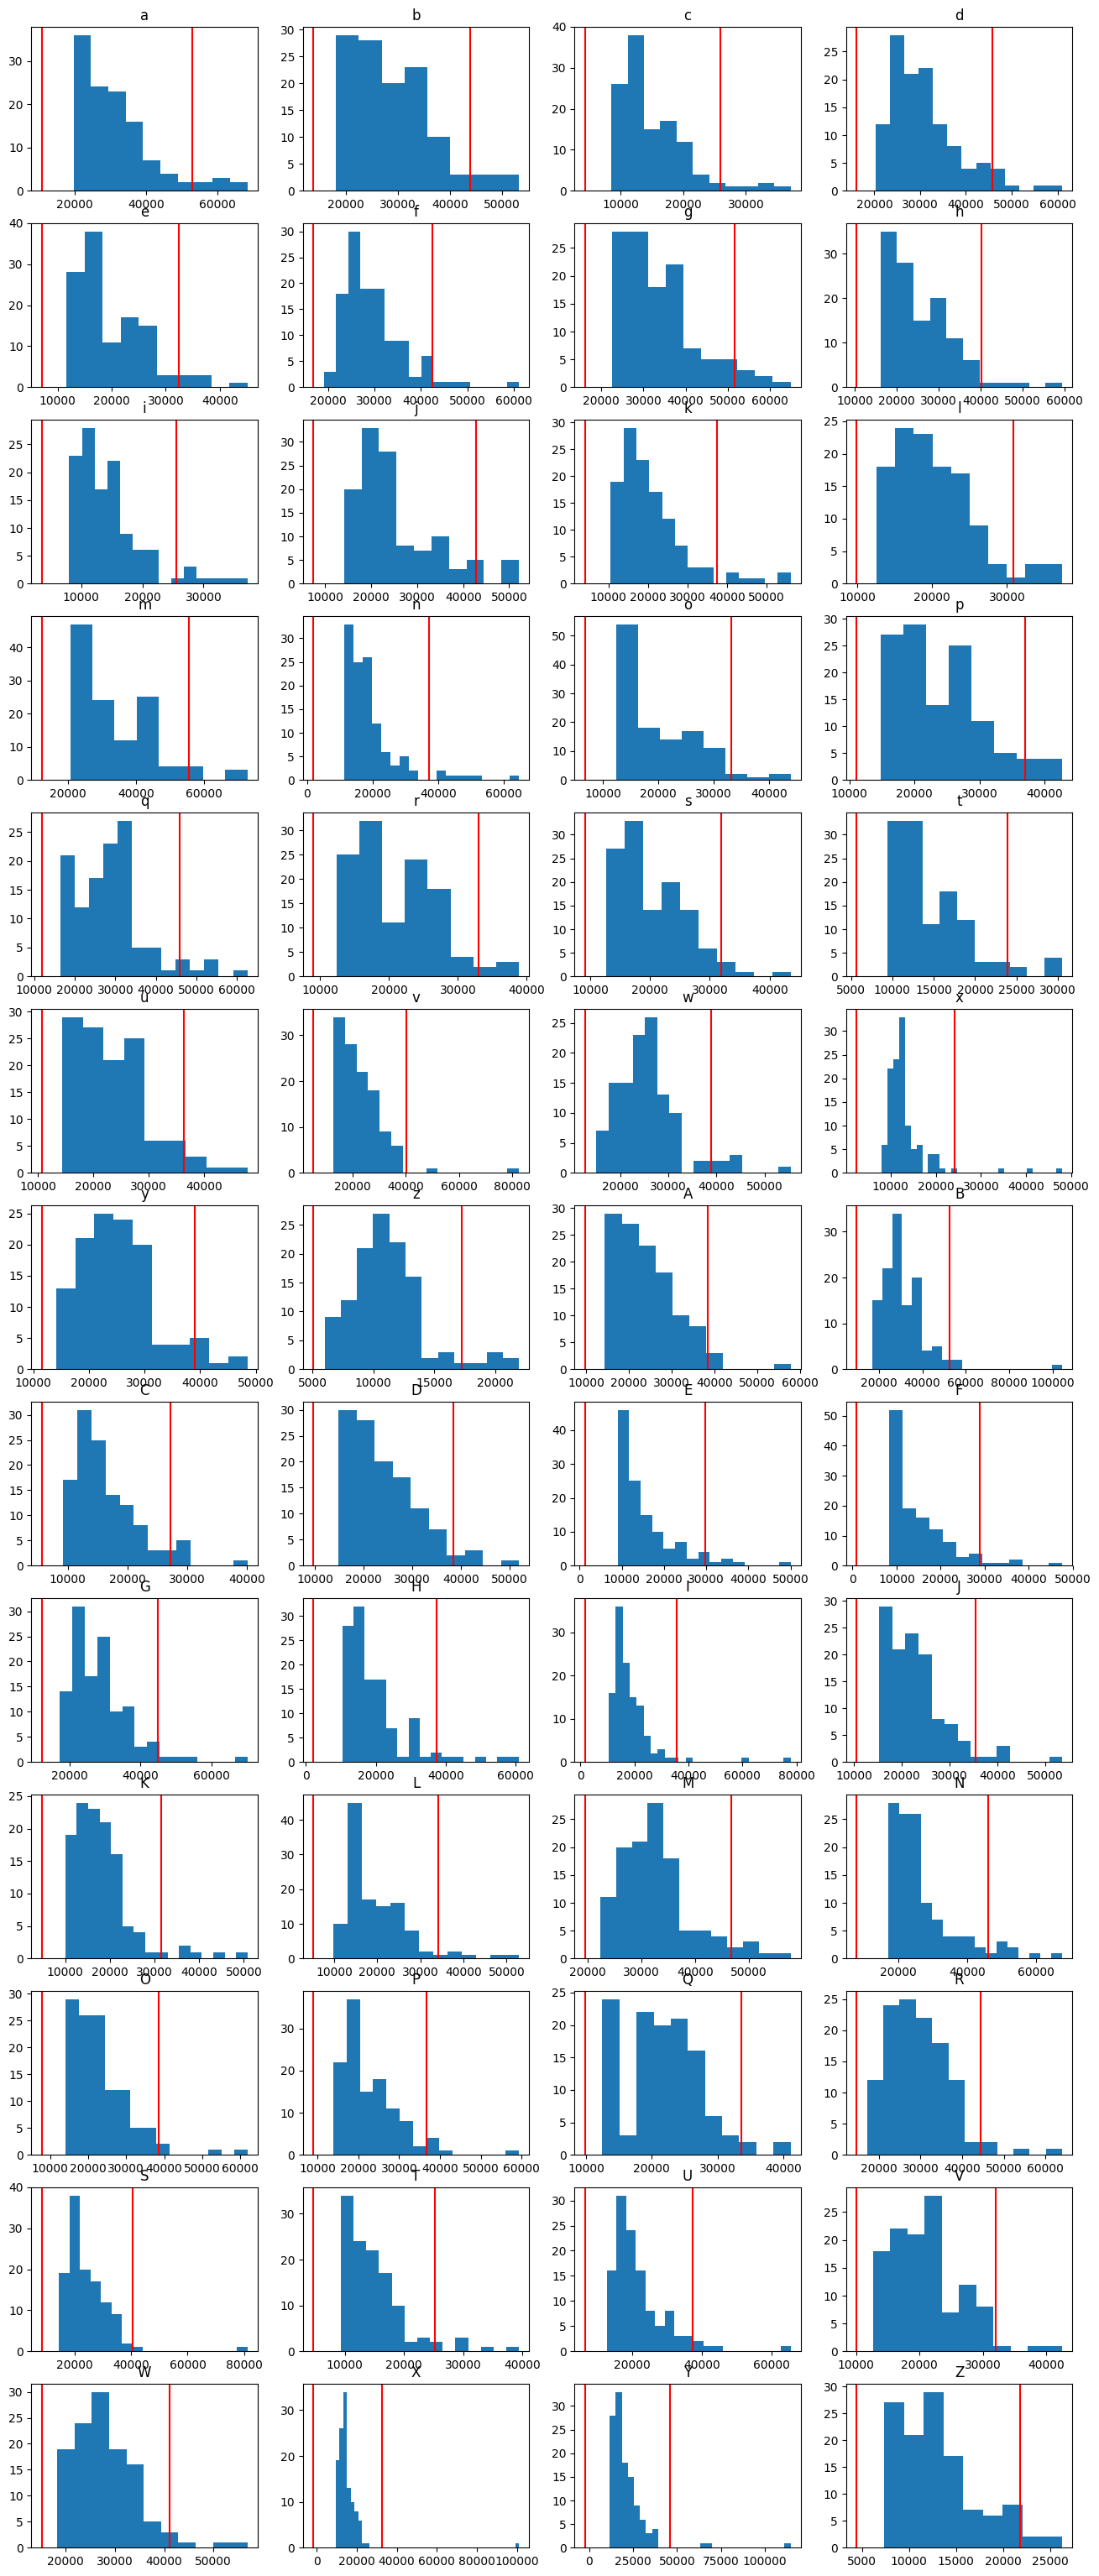

In [42]:
letter_list = loadAllLetters()

# Some more drawings...
rows, cols = 13, 4
pyplot.figure(figsize=(4*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    pyplot.subplot(rows, cols, i + 1)
    sample = letter_list[i]
    plotHist(sample)
    

In [37]:

charList = list(string.ascii_letters)
print(len(charList))
8*6

52


48

In [0]:
def filterHighestDistances(d, factor):
  dd = d.copy()
  dd['indexes'] = list(range(len(d['dtw_matrix'])))
  avg_diss = np.mean(d['dtw_matrix'],axis=1)
  threshold = np.std(avg_diss) * factor
  mu =  np.mean(avg_diss)
  for i in range(len(avg_diss)):
     if avg_diss[i] > mu+ threshold:
        dd['dtw_matrix'][i][0] = -1
        dd['dtw_matrix'][0][i] = -1
        dd['indexes'][i] =  -1
  return  dd

In [0]:
def markDistances(letter_list, factor=1):
  for l in range(len(letter_list)):
    letter_list[l]= filterHighestDistances(letter_list[l], factor)
    
def filterDistance(letter_list, factor=1):
   for l in range(len(letter_list)):
      arr = letter_list[l]['dtw_matrix']
      condition = np.mod(arr, 3)==0

In [0]:
def plotMatrix(letter):
  pyplot.matshow(letter['dtw_matrix'],cmap='plasma')
  pyplot.title(letter['letter'])
  

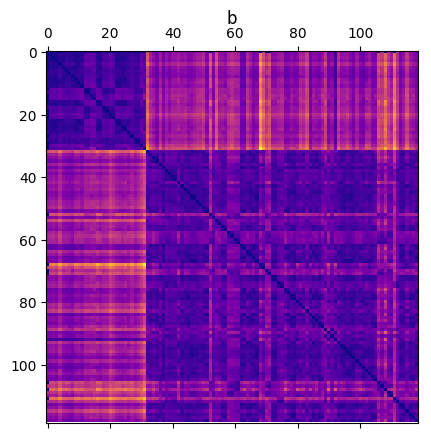

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


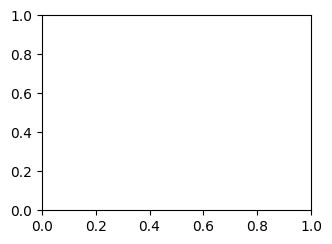

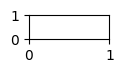

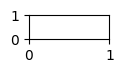

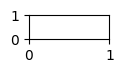

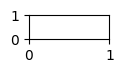

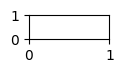

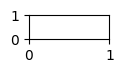

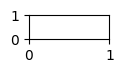

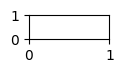

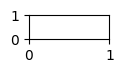

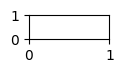

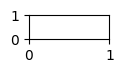

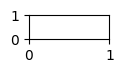

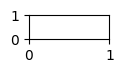

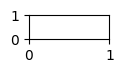

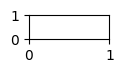

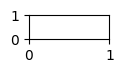

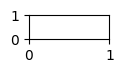

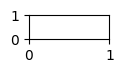

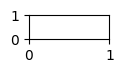

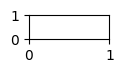

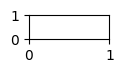

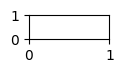

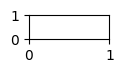

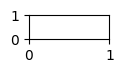

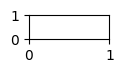

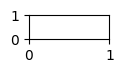

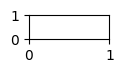

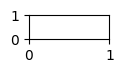

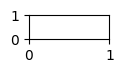

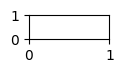

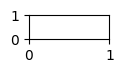

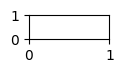

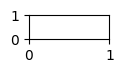

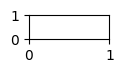

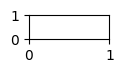

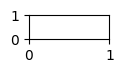

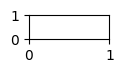

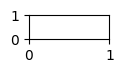

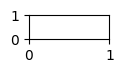

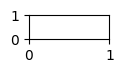

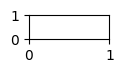

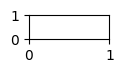

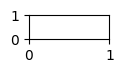

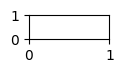

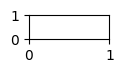

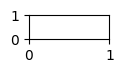

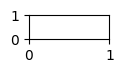

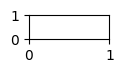

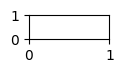

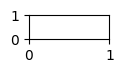

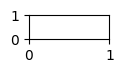

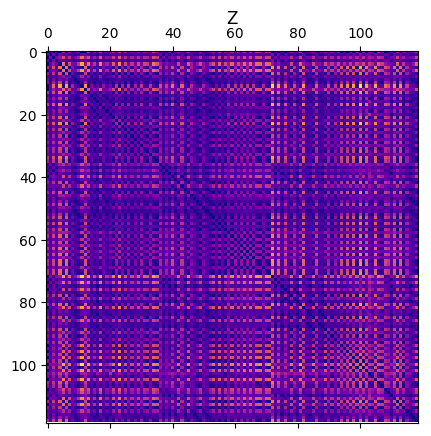

In [64]:
# Some more drawings...
rows, cols = 13, 4
pyplot.figure(figsize=(4*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    pyplot.subplot(rows, cols, i + 1)
    sample = letter_list[i]
    plotMatrix(sample)   

## Histogram

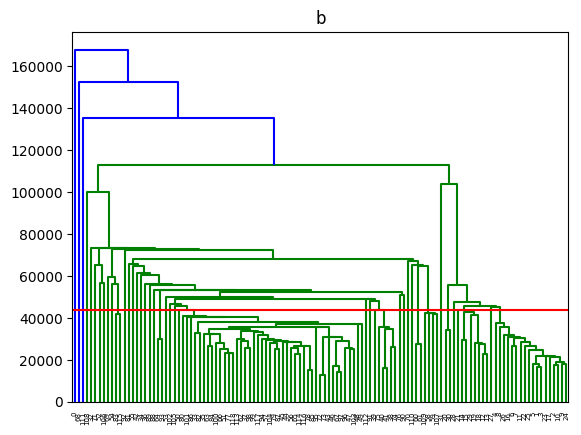

In [70]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, ward, fcluster, leaves_list
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt



def dendoLetter(letter):
  d = letter['dtw_matrix']
  cf = np.mean(d,axis=1)
  Z = linkage(d)
  labelList = range(1, 4)
   
  t1 = np.mean(cf) + 2*np.std(cf)
  
  pyplot.axhline(y=t1, color='r')
  pyplot.title(letter['letter'])


  dendrogram(Z,  
              orientation='top',
              labels=range(len(d)),
              distance_sort='ascending',
              show_leaf_counts=True)

  #T = fcluster(Z, 6, criterion='maxclust')
  #return T


dendoLetter(letter_list[1])


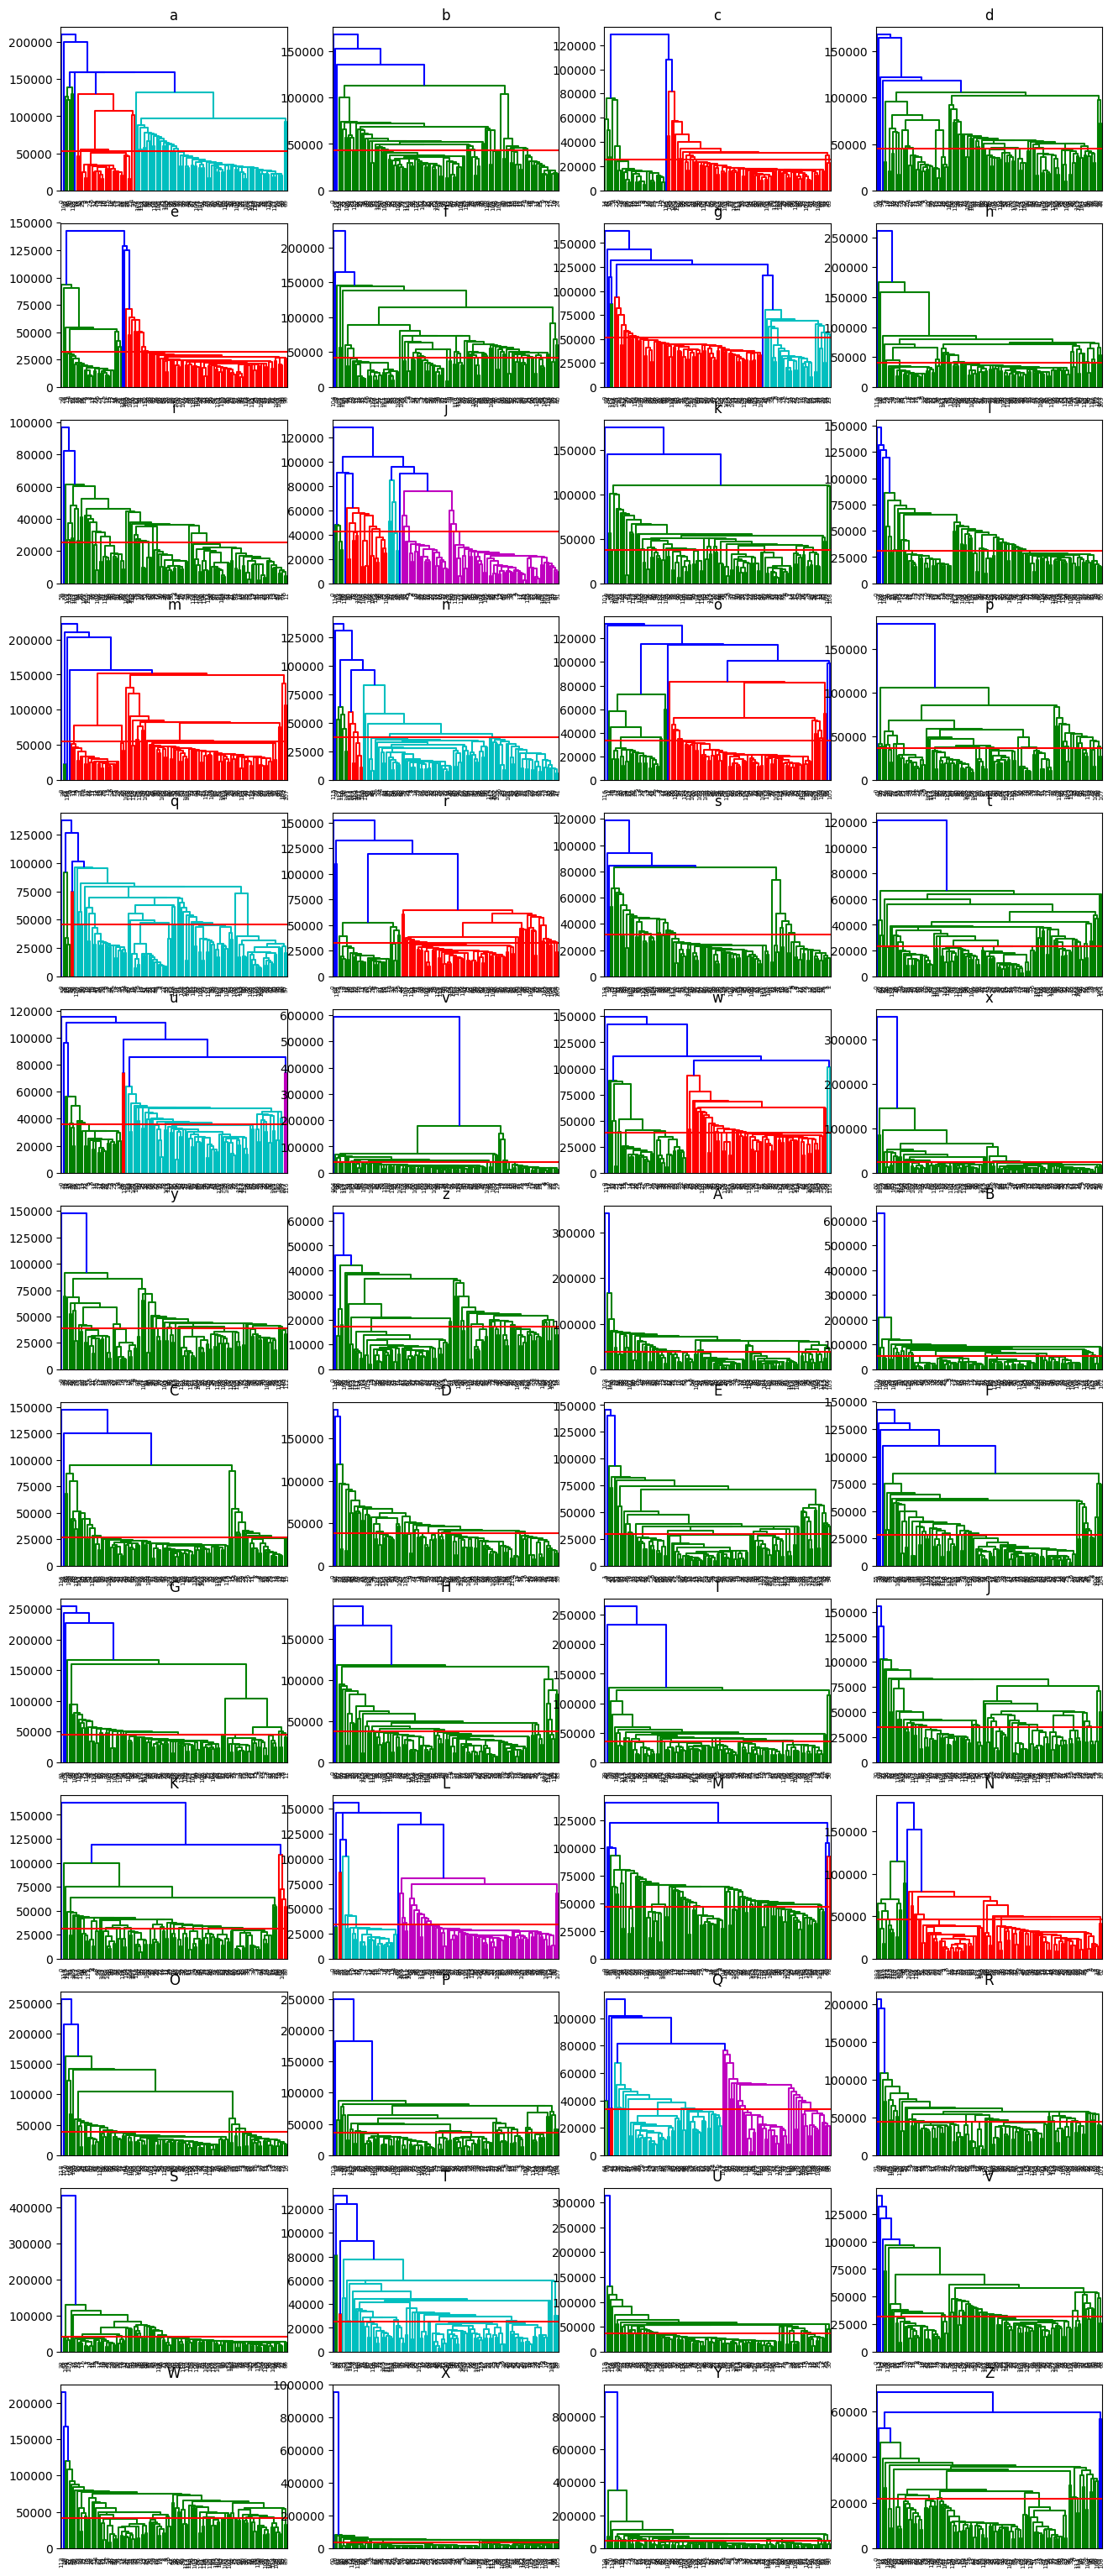

In [61]:
# Some more drawings...
rows, cols = 13, 4
pyplot.figure(figsize=(4*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    pyplot.subplot(rows, cols, i + 1)
    sample = letter_list[i]
    dendoLetter(sample)
    